Running auto_arima (SARIMAX) to find optimal parameters with exogenous variables...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=250.178, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=250.028, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=250.165, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=351.488, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=248.144, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=250.043, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=252.045, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=250.104, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=246.407, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=246.940, Time=0.24 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=249.106, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[12

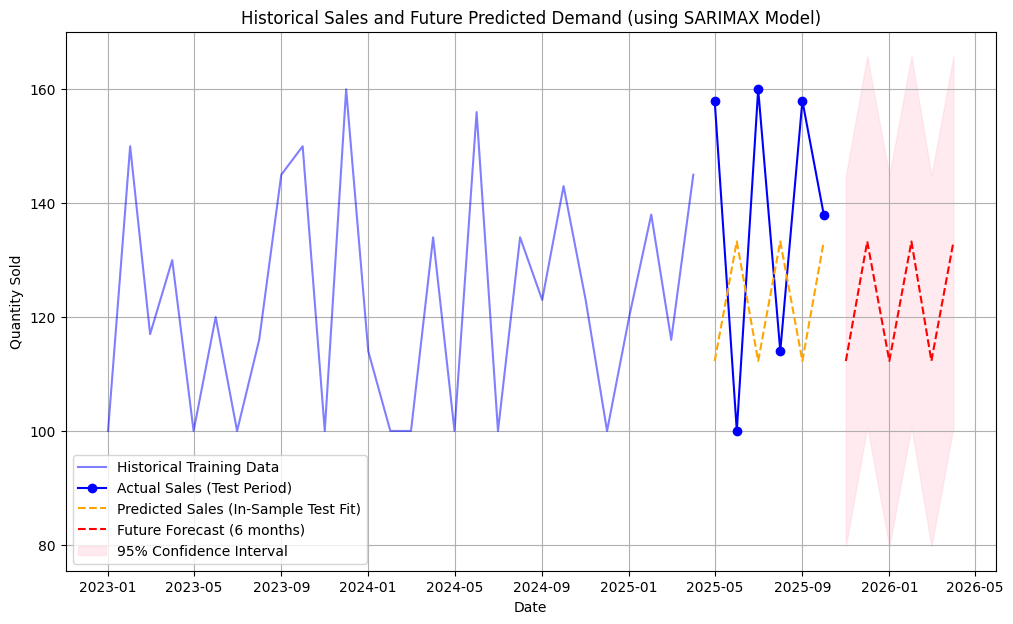

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# --- Step 1: Load and Clean Data (Modified for Exogenous Variable 'PromotionApplied') ---
try:
    # NOTE: Your CSV MUST NOW contain a column named 'PromotionApplied' with 'Y' or 'N'
    data = pd.read_csv('Historical_Sales1.csv')
    df = pd.DataFrame(data)  
except FileNotFoundError:
    print("Error: Historical_Sales1.csv not found. Make sure it contains 'QuantitySold' and 'PromotionApplied' columns.")
    exit()

df = df.replace(' ', np.nan)
df['QuantitySold'] = pd.to_numeric(df['QuantitySold'], errors='coerce')

# --- CRUCIAL CHANGE: Map 'Y'/'N' to 1/0 and prepare the new column ---
# We create a new numeric column 'Is_Promotion' that the model can read
df['Is_Promotion'] = df['PromotionApplied'].map({'Y': 1, 'N': 0}).astype(int)
df.dropna(inplace=True) # Drop rows if any essential data is missing

df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# --- Step 2: Split Data (Training and Test/Future Period) ---
forecast_period = 6 
train_data = df[:-forecast_period]
test_data = df[-forecast_period:]

# Define which columns are the target variable and which are exogenous features
target_variable = 'QuantitySold'
exogenous_features = ['Is_Promotion'] # Use the new numeric column here

X_train = train_data[exogenous_features]
y_train = train_data[target_variable]
X_test = test_data[exogenous_features]
y_test = test_data[target_variable]

# You need to define your assumption for future promotions to forecast forward! 
# Example: assuming NO promotions planned for the future 6 months:
X_future_forecast = pd.DataFrame(
    {'Is_Promotion': [0] * forecast_period}, # List of 6 zeros for no promotion
    index=pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=forecast_period, freq='MS')
)
# If you had 2 months of 'Y' and 4 months of 'N' planned:
# X_future_forecast = pd.DataFrame({'Is_Promotion': [1, 1, 0, 0, 0, 0]}, ...)


# --- Step 3: Configure and Fit the SARIMAX Model using auto_arima ---
print("Running auto_arima (SARIMAX) to find optimal parameters with exogenous variables...")

# Pass the exogenous training data (X_train) to the model fitting process
auto_model_sarimax = pm.auto_arima(y=y_train, # Target variable
                                   exogenous=X_train, # Exogenous features
                                   seasonal=True, m=12,  
                                   trace=True,
                                   suppress_warnings=True,
                                   stepwise=True,
                                   n_jobs=-1)

print("\nOptimal SARIMAX Model Summary:")
print(auto_model_sarimax.summary())

# --- Step 4: Generate Predictions (In-sample and Out-of-sample) ---

# To predict the test period, pass the test exogenous data (X_test)
predicted_mean_test = auto_model_sarimax.predict(n_periods=forecast_period, 
                                                 exogenous=X_test)
predicted_mean_test.index = test_data.index

# Calculate MSE for validation on the test set
mse = mean_squared_error(y_test, predicted_mean_test)
print(f'\nMean Squared Error on Test Data: {mse}')

# Generate *future* forecasts beyond the historical data range
# To predict the FUTURE, you MUST provide the expected future exogenous data (X_future_forecast)
forecast_mean, forecast_ci = auto_model_sarimax.predict(n_periods=forecast_period, 
                                                        return_conf_int=True,
                                                        exogenous=X_future_forecast)

forecast_mean.index = X_future_forecast.index
forecast_ci_df = pd.DataFrame(forecast_ci, index=forecast_mean.index, columns=['lower', 'upper'])


# --- Add this code snippet after Step 4 (after the test data output) ---

print("\n--- Future Forecast (6 months) ---")

# Prepare data for a Pandas DataFrame
future_data = []

# Iterate through the forecast mean (which is a Pandas Series with dates as index)
for date, mean_pred in forecast_mean.items():
    future_data.append({
        'Date': date.strftime('%Y-%m'),
        'Predicted Sales': round(mean_pred) # Rounding to the nearest whole number
    })

# Create a DataFrame from the prepared list
forecast_table = pd.DataFrame(future_data)

# Print the DataFrame in a neat tabular format to the console
# Using to_string() ensures all rows are displayed cleanly without truncation
print(forecast_table.to_string(index=False))


# --- Step 5: Visualization (Same as before) ---
plt.figure(figsize=(12, 7))
plt.plot(train_data.index, train_data[target_variable], label='Historical Training Data', color='blue', alpha=0.5)
plt.plot(test_data.index, test_data[target_variable], label='Actual Sales (Test Period)', color='blue', marker='o')
plt.plot(predicted_mean_test.index, predicted_mean_test, label='Predicted Sales (In-Sample Test Fit)', color='orange', linestyle='--')
plt.plot(forecast_mean.index, forecast_mean, label=f'Future Forecast ({forecast_period} months)', color='red', linestyle='--')
plt.fill_between(forecast_ci_df.index,
                 forecast_ci_df['lower'],
                 forecast_ci_df['upper'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title('Historical Sales and Future Predicted Demand (using SARIMAX Model)')
plt.legend()
plt.grid(True)
plt.show()


Fitting SARIMAX model with manual parameters...

Manual SARIMAX Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                       QuantitySold   No. Observations:                   28
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 -61.451
Date:                            Tue, 25 Nov 2025   AIC                            132.903
Time:                                    21:59:30   BIC                            136.098
Sample:                                01-01-2023   HQIC                           132.607
                                     - 04-01-2025                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        3.0834      6.

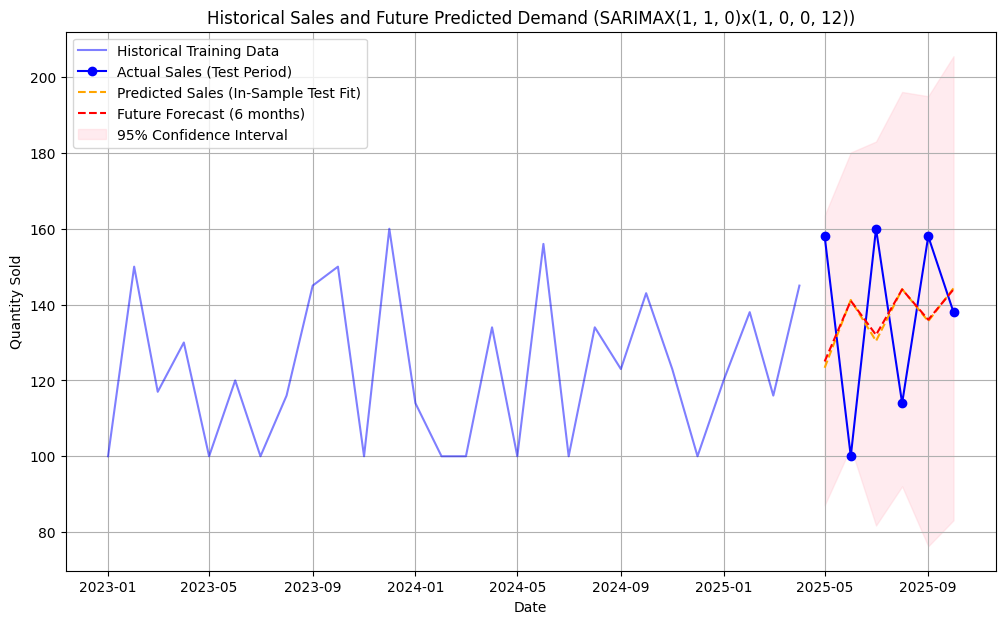

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import the specific SARIMAX class from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# --- Step 1: Load and Clean Data ---
try:
    data = pd.read_csv('Historical_Sales1.csv')
    df = pd.DataFrame(data)  
except FileNotFoundError:
    print("Error: Historical_Sales1.csv not found. Make sure it contains 'QuantitySold' and 'PromotionApplied' columns.")
    exit()

df = df.replace(' ', np.nan)
df['QuantitySold'] = pd.to_numeric(df['QuantitySold'], errors='coerce')
# Map 'Y'/'N' to 1/0 for the model
df['Is_Promotion'] = df['PromotionApplied'].map({'Y': 1, 'N': 0}).astype(int) 
df.dropna(inplace=True) 

df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# --- Step 2: Split Data ---
forecast_period = 6
train_data = df[:-forecast_period]
test_data = df[-forecast_period:]

target_variable = 'QuantitySold'
exogenous_features = ['Is_Promotion']

X_train = train_data[exogenous_features]
y_train = train_data[target_variable]
X_test = test_data[exogenous_features]
y_test = test_data[target_variable]

# Define future exogenous data (e.g., assuming no promotions planned for future 6 months)
X_future_forecast = pd.DataFrame(
   {'Is_Promotion': [0] * forecast_period}, # List of 6 zeros for no promotion
    index=pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=forecast_period, freq='MS')
)


# --- Step 3: Configure and Fit the SARIMAX Model Manually ---

print("Fitting SARIMAX model with manual parameters...")

# Define the model orders:
# Non-seasonal order (p, d, q)
# Seasonal order (P, D, Q, s) where s=12 months
# The previous auto_arima suggested (1,0,1)x(0,0,0,12) with a constant trend
# We will try a more seasonal-aware model: e.g., (1, 0, 1)x(1, 1, 0, 12)
# (P=1, D=1, Q=0, s=12) introduces seasonal differencing and AR terms.

manual_order = (1, 1, 0)
manual_seasonal_order = (1, 0, 0, 12) 

# Initialize the SARIMAX model instance
model = SARIMAX(
    endog=y_train, 
    exog=X_train, # Pass the training exogenous data
    order=manual_order,
    seasonal_order=manual_seasonal_order,
    # enforce_stationarity and enforce_invertibility are useful for stability
    enforce_stationarity=False, 
    enforce_invertibility=False,
    trend='c' # Include a constant trend/intercept
)

# Fit the model
results = model.fit(disp=False) # Use disp=False to suppress detailed iteration output

print("\nManual SARIMAX Model Summary:")
print(results.summary())


# --- Step 4: Generate Predictions (In-sample and Out-of-sample) ---

# Get in-sample predictions for the test period
# Use the .get_forecast() method for more control over confidence intervals
forecast_test_period = results.get_forecast(steps=forecast_period, exog=X_test)
predicted_mean_test = forecast_test_period.predicted_mean
predicted_mean_test.index = test_data.index

# Calculate MSE for validation on the test set
mse = mean_squared_error(y_test, predicted_mean_test)
# print(f'\nMean Squared Error on Test Data: {mse}')
# Format Actual Sales and Predicted Sales into clean lists for output
actual_sales_list = y_test.tolist()
# Note: predicted_mean_test is either a Pandas Series or Numpy array depending on the script used
predicted_sales_list = predicted_mean_test.tolist() 

# Format the MSE value to two decimal places
formatted_mse = round(mse, 2)

# Print the output in the desired format
print(f"Mean Squared Error on Test Data: {formatted_mse}")
print(f"Actual Sales: {actual_sales_list}")
print(f"Predicted Sales: {predicted_sales_list}")

# Generate *future* forecasts beyond the historical data range
# To predict the FUTURE, you MUST provide the expected future exogenous data
forecast_future = results.get_forecast(steps=forecast_period, exog=X_future_forecast)
forecast_mean = forecast_future.predicted_mean.round(0) # Round predictions immediately
forecast_ci_df = forecast_future.conf_int(alpha=0.05) # Get 95% confidence intervals


# --- Add this code snippet after Step 4 (after the test data output) ---

print("\n--- Future Forecast (6 months) ---")

# Prepare data for a Pandas DataFrame
future_data = []

# Iterate through the forecast mean (which is a Pandas Series with dates as index)
for date, mean_pred in forecast_mean.items():
    future_data.append({
        'Date': date.strftime('%Y-%m'),
        'Predicted Sales': round(mean_pred) # Rounding to the nearest whole number
    })

# Create a DataFrame from the prepared list
forecast_table = pd.DataFrame(future_data)

# Print the DataFrame in a neat tabular format to the console
# Using to_string() ensures all rows are displayed cleanly without truncation
print(forecast_table.to_string(index=False))

# --- Step 5: Visualization ---
plt.figure(figsize=(12, 7))
plt.plot(train_data.index, train_data[target_variable], label='Historical Training Data', color='blue', alpha=0.5)
plt.plot(test_data.index, test_data[target_variable], label='Actual Sales (Test Period)', color='blue', marker='o')
plt.plot(predicted_mean_test.index, predicted_mean_test, label='Predicted Sales (In-Sample Test Fit)', color='orange', linestyle='--')
plt.plot(forecast_mean.index, forecast_mean, label=f'Future Forecast ({forecast_period} months)', color='red', linestyle='--')
plt.fill_between(forecast_ci_df.index,
                 forecast_ci_df.iloc[:, 0],
                 forecast_ci_df.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title(f'Historical Sales and Future Predicted Demand (SARIMAX{manual_order}x{manual_seasonal_order})')
plt.legend()
plt.grid(True)
plt.show()


Fitting SARIMAX model with manual parameters...

Manual SARIMAX Model Summary:
Mean Squared Error on Test Data: 453.24
Actual Sales: [123, 100, 120, 138, 116, 145, 158, 100, 160, 114, 158, 138]
Predicted Sales: [122.7487734757579, 146.21462386767078, 127.23741815772199, 143.88589978271202, 129.9837710301515, 134.9704212177176, 139.64835343583957, 134.65750138534534, 140.89407431040152, 134.74291807114335, 133.95948549738537, 135.04908531699138]

--- Future Forecast (6 months) ---
   Date  Predicted Sales
2025-11              123
2025-12              138
2026-01              127
2026-02              136
2026-03              130
2026-04              135
2026-05              132
2026-06              135
2026-07              133
2026-08              135
2026-09              134
2026-10              135


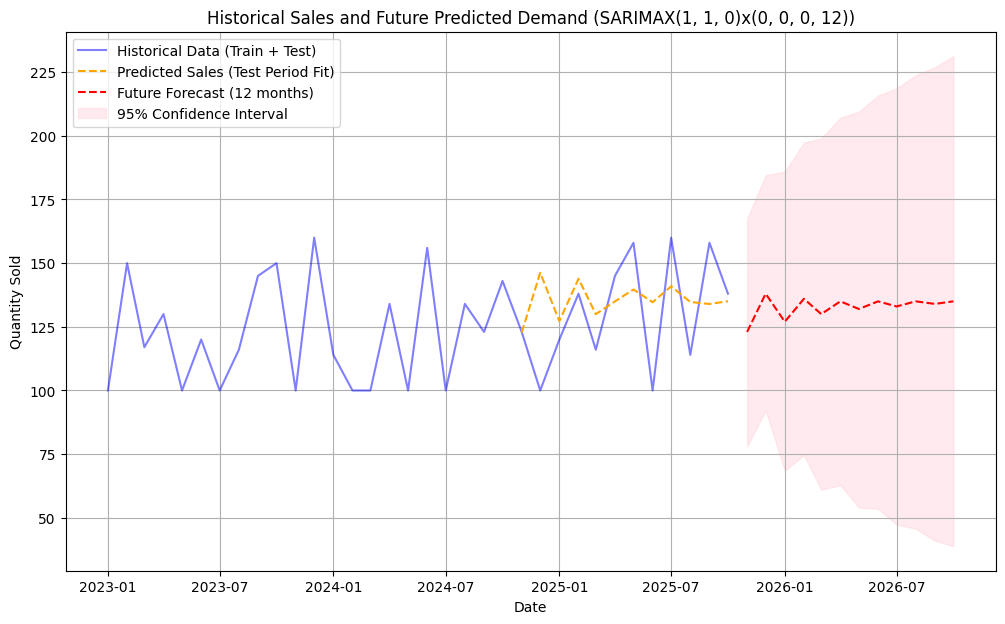

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# --- Step 1: Load and Clean Data ---
try:
    data = pd.read_csv('Historical_Sales1.csv')
    df = pd.DataFrame(data)  
except FileNotFoundError:
    print("Error: Historical_Sales1.csv not found. Make sure it contains 'QuantitySold' and 'PromotionApplied' columns.")
    exit()

df = df.replace(' ', np.nan)
df['QuantitySold'] = pd.to_numeric(df['QuantitySold'], errors='coerce')
df['Is_Promotion'] = df['PromotionApplied'].map({'Y': 1, 'N': 0}).astype(int) 
df.dropna(inplace=True) 

df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# --- Step 2: Split Data ---

# Define the total period we want to forecast beyond the training data
# 6 months for test period + 6 months for future prediction = 12 steps beyond training end
# If you want 6 months of test + 12 months of future prediction = 18 steps total
total_future_steps = 12 # We want 12 months of *true* future forecast beyond the test data
test_period_steps = 12
train_data = df[:-test_period_steps]
test_data = df[-test_period_steps:]

# Use a new variable name for the total future steps to avoid confusion
# We need to forecast `total_future_steps` *beyond* the end of the full historical data
forecast_horizon = 12

target_variable = 'QuantitySold'
exogenous_features = ['Is_Promotion']

X_train = train_data[exogenous_features]
y_train = train_data[target_variable]
X_test = test_data[exogenous_features]
y_test = test_data[target_variable]

# Define future exogenous data for the NEXT 12 MONTHS (Nov 2025 - Oct 2026 if your data ends Oct 2025)
# You need to define the promotional strategy for these future months.
# Example: 12 zeros for no promotions in the next year
X_future_forecast = pd.DataFrame(
    {'Is_Promotion': [0] * forecast_horizon}, 
    index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
)


# --- Step 3: Configure and Fit the SARIMAX Model Manually ---
print("Fitting SARIMAX model with manual parameters...")

manual_order = (1, 1, 0)
manual_seasonal_order = (0, 0, 0, 12) 

model = SARIMAX(
    endog=y_train, 
    exog=X_train, 
    order=manual_order,
    seasonal_order=manual_seasonal_order,
    enforce_stationarity=False, 
    enforce_invertibility=False,
    trend='c' 
)

results = model.fit(disp=False) 
print("\nManual SARIMAX Model Summary:")
# print(results.summary()) # Commenting out summary for brevity

# --- Step 4: Generate Predictions (In-sample and Out-of-sample) ---

# Get in-sample predictions for the test period (6 months)
forecast_test_period = results.get_forecast(steps=test_period_steps, exog=X_test)
predicted_mean_test = forecast_test_period.predicted_mean
predicted_mean_test.index = test_data.index

# Calculate MSE for validation on the test set
mse = mean_squared_error(y_test, predicted_mean_test)
actual_sales_list = y_test.tolist()
predicted_sales_list = predicted_mean_test.tolist() 

formatted_mse = round(mse, 2)

print(f"Mean Squared Error on Test Data: {formatted_mse}")
print(f"Actual Sales: {actual_sales_list}")
print(f"Predicted Sales: {predicted_sales_list}")

# Generate *future* forecasts beyond the historical data range (12 months)
# We use the new forecast_horizon variable here
forecast_future = results.get_forecast(steps=forecast_horizon, exog=X_future_forecast)
forecast_mean = forecast_future.predicted_mean.round(0) 
forecast_ci_df = forecast_future.conf_int(alpha=0.05) 

# >>>>> CRITICAL FIX: Ensure the DatetimeIndex is assigned to the forecast results
# .get_forecast() doesn't always automatically use the exog index when 'steps' is provided
forecast_mean.index = X_future_forecast.index
forecast_ci_df.index = X_future_forecast.index 

print("\n--- Future Forecast (6 months) ---")

# Prepare data for a Pandas DataFrame
future_data = []

# Iterate through the forecast mean (which is a Pandas Series with dates as index)
for date, mean_pred in forecast_mean.items():
    future_data.append({
        'Date': date.strftime('%Y-%m'),
        'Predicted Sales': round(mean_pred) # Rounding to the nearest whole number
    })

# Create a DataFrame from the prepared list
forecast_table = pd.DataFrame(future_data)

# Print the DataFrame in a neat tabular format to the console
# Using to_string() ensures all rows are displayed cleanly without truncation
print(forecast_table.to_string(index=False))


# --- Step 5: Visualization ---
# The rest of your plotting code remains the same...

# --- Step 5: Visualization ---
plt.figure(figsize=(12, 7))
plt.plot(df.index, df[target_variable], label='Historical Data (Train + Test)', color='blue', alpha=0.5) # Plot all historical data now
# We can skip plotting the test specific points if we plot all historical data above
plt.plot(predicted_mean_test.index, predicted_mean_test, label='Predicted Sales (Test Period Fit)', color='orange', linestyle='--')
plt.plot(forecast_mean.index, forecast_mean, label=f'Future Forecast ({forecast_horizon} months)', color='red', linestyle='--')
plt.fill_between(forecast_ci_df.index,
                 forecast_ci_df.iloc[:, 0],
                 forecast_ci_df.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title(f'Historical Sales and Future Predicted Demand (SARIMAX{manual_order}x{manual_seasonal_order})')
plt.legend()
plt.grid(True)
plt.show()
